In [1]:
'''
Multi-class image classification for an Emotion Recognition task.
'''

from keras.utils import to_categorical
import wandb
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import os

## PARAMETERS ##
print_tensorflow_GPU_info = False
wandb.init(entity='unreal', project='Basic_FER_image_classification', name=None, notes=None, anonymous=None)
config = wandb.config  # config is a variable that holds and saves hyperparameters and inputs
config.random_state = 22
config.tensorflow_verbosity = "INFO"  # DEBUG(10): All | INFO(20): Info&Warning | WARN(30)[Default]: Warning | ERROR(40): Error | FATAL(50): None
    # General
config.load_npy = False
config.dataset = "./Datasets/FER-2013/fer2013.csv"
config.num_features = 64
config.num_labels = 7
config.width, config.height = 48, 48
    # Convolution
#config.kernel_size = 
#config.filters = 
#config.pool_size = 
    # Training
config.batch_size = 64
config.epochs = 50
config.loss="binary_crossentropy"
config.optimizer="adam"
config.eval_metrics="accuracy"
##             ##

## Reproducibility ## 
random.seed(config.random_state)  # Python's seed
np.random.seed(config.random_state)  # Numpy's seed
tf.set_random_seed(config.random_state)  # Tensorflow's seed
##                 ##

Using TensorFlow backend.


In [2]:
## RTX GPU Memory BUG Fix & Must also be placed at the top of the code else it doesn't work ##
from keras.backend import tensorflow_backend as K
tf_config = tf.compat.v1.ConfigProto()
tf_config.gpu_options.allow_growth = True                     # dynamically grow the memory used on the GPU
#tf_config.gpu_options.per_process_gpu_memory_fraction = 0.9  # fraction of the GPU to be used
#tf_config.log_device_placement = True                        # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=tf_config)
K.set_session(sess)                     # set this TensorFlow session as the default session for Keras
##                                                                                          ##     

## Tensorflow Verbosity Module ##
default_verbosity = tf.compat.v1.logging.get_verbosity()
tf.compat.v1.logging.set_verbosity(config.tensorflow_verbosity)
print(f"\n--CHANGED TENSORFLOW VERBOSITY FROM {default_verbosity/10:.0f} (default) TO {tf.compat.v1.logging.get_verbosity()/10:.0f}")
##                             ##

## Tensorflow GPU Information Module ##
if print_tensorflow_GPU_info == True:
    print(f"\n--AVAILABLE GPUS:")
    K._get_available_gpus()
    print(f"\n--NUM OF GPUs AVAILABLE: {len(tf.config.experimental.list_physical_devices('GPU'))}")
    print(f"\n--IS TF BUILT WITH CUDA: {tf.test.is_built_with_cuda()}")
    print(f"\n--IS GPU AVAILABLE: {tf.test.is_gpu_available()}")
##                                   ##  


--CHANGED TENSORFLOW VERBOSITY FROM 2 (default) TO 2


## Data Loading and Preprocessing: Save Mode

In [4]:
# Data Loading and Preprocessing 
if config.load_npy == False:
    data = pd.read_csv(config.dataset)
    data.rename(columns={"emotion": "label"}, inplace=True)
    display(data.head())

    # if config.dataset == "MNIST":
    #    train_data = pd.read_csv("./Datasets/MNIST/digit-recognizer/train.csv")
    #    test_data = pd.read_csv("./Datasets/MNIST/digit-recognizer/test.csv")

    print("\nEach instance consists of:", len(data.iloc[0, [1]].values[0].split()), "pixels")
    datapoints = data['pixels'].tolist()

    # Convert a sequence of pixels to YxY
    X = []
    for xseq in datapoints:
        xx = [int(xp) for xp in xseq.split(' ')]
        xx = np.asarray(xx).reshape(config.width, config.height)
        X.append(xx.astype('float32'))

    X = np.asarray(X)
    X = np.expand_dims(X, -1)

    # Get Labels
    y = to_categorical(data['label'])

    # Get train/tase usage mask
    train_test_usage = data['Usage'].values
    tmask = np.isin(train_test_usage, 'Training')

    print("Loading and Preprocessing Done")
    print("Number of Features: " + str(X[0].shape))
    print("Number of Class Labels: " + str(len(y[0])))
    print("Number of instances in dataset: " + str(len(X)))

    # Store data as .npy
    np.save('./Datasets/FER-2013/fdata', X)
    np.save('./Datasets/FER-2013/flabels', y)
    np.save('./Datasets/FER-2013/ftraintestmask', tmask)
    print("Data and labels got stored to .npy files")

,label,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training



Each instance consists of: 2304 pixels
Loading and Preprocessing Done
Number of Features: (48, 48, 1)
Number of Class Labels: 7
Number of instances in dataset: 35887
Data and labels got stored to .npy files


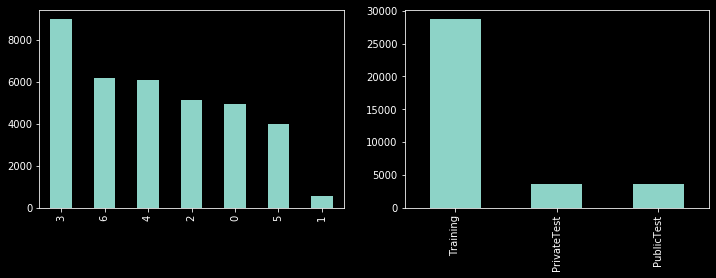

In [84]:
# Class and test/train distribution visualizations (only for Save Mode)
if config.load_npy == False:
    fig = plt.figure(figsize=[12, 8])
    ax1 = fig.add_subplot(221)
    data['label'].value_counts().plot.bar()
    ax2 = fig.add_subplot(222)
    data['Usage'].value_counts().plot.bar()

## Data Loading and Preprocessing: Load Mode

For class and test/train distribution visualizations use Save Mode

In [37]:
# Load data from .npy files
if config.load_npy == True:
    X = np.load('fdata.npy')
    y = np.load('flabels.npy')
    tmask = np.load('ftraintestmask.npy')
    print("Data loaded from .npy files")

## Random samples visualization

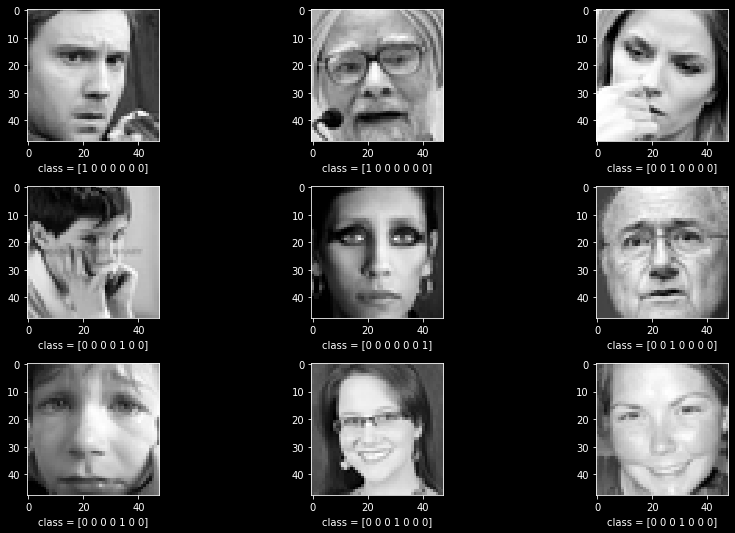

In [53]:
plt.figure(figsize=(12, 12))
for i, pixels in enumerate(X[0:9]):
    plt.subplot(5, 3, i+1)
    plt.imshow(pixels[:,:,0], cmap='gray')  # (256L, 256L, 1L) cannot be plotted therefore we need to get rid of the last dimension -> (256L, 256L)
    plt.xlabel("class = " + "{}".format(y[i])) 
plt.tight_layout()
plt.show()

In [8]:
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()

#num_instances, num_features = temp_data.shape
#temp_data = np.reshape(temp_data, newshape=(-1, num_features))
#temp_data = scaler.fit_transform(temp_data)

## Train/test splitting

In [10]:
# Train/test splitting


#from sklearn.model_selection import train_test_split
#x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)


Using TensorFlow backend.


In [11]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=10,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)
train_datagen.fit(x_train)
train_generator = train_datagen.flow(
    x_train,
    y_train,
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=1./255)
train_datagen.fit(x_test)
validation_generator = validation_datagen.flow(
    x_test,
    y_test
    
)

# Build CNN Model

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

In [13]:
if dataset == "MNIST":

    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(48,48,1)))
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(7, activation='softmax'))

# Compile Model

In [14]:
if dataset == "MNIST":
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks

In [15]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

# Fit model

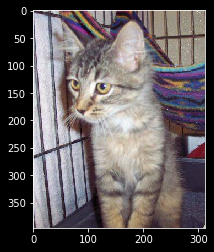

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load an color image in grayscale
img = cv2.imread('cat.2.jpg',1)
cv2.imshow('image',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

# or for a specific key
#while(1):
#    cv2.imshow('image',img)
#    if cv2.waitKey(20) & 0xFF == 27:
#        break
#cv2.destroyAllWindows()

#Import image
# OpenCV uses BGR, Matplotlib uses RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [31]:
import numpy as np
import cv2

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')

In [16]:


from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from keras.layers import Dense, Dropout, Activation, Flatten

model = Sequential()

model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(num_labels, activation='softmax'))

#model.summary()

#Compliling the model with adam optimixer and categorical crossentropy loss
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

#training the model
model.fit(np.array(x_train), np.array(y_train),
          batch_size=batch_size,
          epochs=5,
          verbose=1,
          validation_split=0.1,
          shuffle=True,
          callbacks=callbacks)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Train on 29068 samples, validate on 3230 samples
Epoch 1/20
29068/29068 [==============================] - 23s 807us/step - loss: 1.8967 - accuracy: 0.2324 - val_loss: 1.8092 - val_accuracy: 0.2650

Epoch 00001: val_loss improved from inf to 1.80919, saving model to model.h5
Epoch 2/20
29068/29068 [==============================] - 31s 1ms/step - loss: 1.6785 - accuracy: 0.3227 - val_loss: 1.6502 - val_accuracy: 0.3517

Epoch 00002: val_loss improved from 1.80919 to 1.65017, saving model to model.h5
Epoch 3/20
29068/29068 [==============================] - 50s 2ms/step - loss: 1.4567 - accuracy: 0.4408 - val_loss: 1.5817 - val_accuracy: 0.3802

Epoch 00003: val_loss improved from 1.65017 to 1.58174, saving model to model.h5
Epoch 4/20
29068/29068 [==============================] - 50s 2ms/step - loss: 1.3284 - accuracy: 0.5003 - val_loss: 1.2361 - val_accuracy: 0.5396

Epoch 00004: val_loss improved from

In [17]:
if dataset == "MNIST":
    model.fit(
        x_train, y_train,
        batch_size=batch_size,
        #steps_per_epoch=len(x_train) // batch_size,
        validation_split = 0.1,
        epochs=10,
        callbacks=callbacks
    )

In [18]:
if dataset == "MNIST":
    model.fit_generator(
        train_generator, 
        steps_per_epoch=len(x_train) // batch_size, 
        validation_data=validation_generator,
        validation_steps=len(x_test) // batch_size,
        epochs=epochs,
        callbacks=callbacks
    )

# Evaluate Model

In [24]:
x_test_recaled = (x_test.astype("float32") / 255)
scores = model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))

accuracy: 66.26%
loss: 113.83%


In [20]:
if dataset == "MNIST":
    x_test_recaled = (x_test.astype("float32") / 255)
    scores = model.evaluate(x_test_recaled, y_test, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    print("%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))

# Prediction

In [21]:
test_digit_data = test_data.values.reshape(test_data.shape[0],28,28,1).astype("float32") / 255
predictions = model.predict(test_digit_data)
results = np.argmax(predictions, axis = 1) 

NameError: name 'test_data' is not defined

### Set how is our prediction

In [0]:
plt.figure(figsize=(18, 8))
sample_test = test_data.head(18)
for index, image_pixels in sample_test.iterrows():
    label = results[index]
    show_image(image_pixels, label, index)
plt.tight_layout()

### Create submission file